<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v2)
The first version was a bit of a mission to get to something working and it had so many side experiments. I now want to move forward with a clean baseline in order to make those improvements.

Here I'll focus on improving the loss functions and possibly tweak the data representations if needed.

I want to get to a point where the model trains as well as can be reasonable given the quality of the dataset.

In [82]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout db6fe3a
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

HEAD is now at 21f15b0 show_prediction() now supports omitted inputs and outputs, and optional 'show_classes'
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 362 bytes | 181.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   21f15b0..782d156  main       -> origin/main
Updating 21f15b0..782d156
Fast-forward
 slam_data.py | 3 +--
 1 file changed, 1 insertion(+), 2 deletions(-)


<module 'slam_data' from '/content/repo/slam_data.py'>

In [4]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00


## Training data


In [6]:
# If generated data is available then load that to save time:
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data1.npz')
slam_data.validate_dataset(train_data)

Loaded:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset loaded from repo/data/experimental-slam-training-data1.npz
Dataset tests passed (1000 entries verified)


In [ ]:
# Alternatively, generate new data
np.random.seed(0)
#train_data = generate_training_data(floorplan, 1000)
#train_data = slam_data.generate_training_data(floorplan, 1000, sample_types=[1])
#slam_data.validate_dataset(train_data)

In [ ]:
# Uncomment to save dataset
#save_dataset(train_data, 'experimental-slam-training-data1-type1only.npz')

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


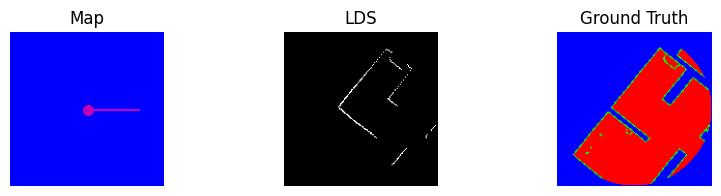

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [0. 0. 0. 0.]


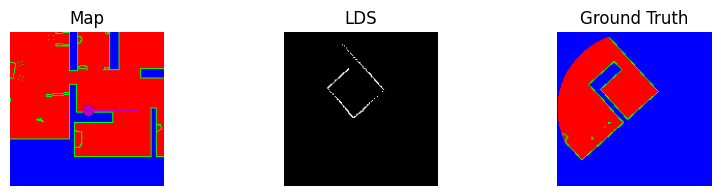

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]


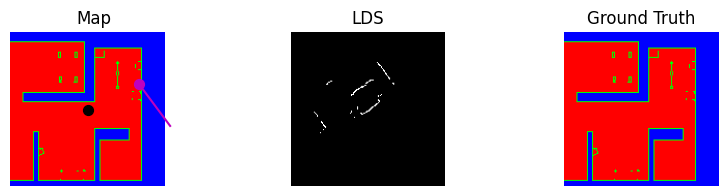

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


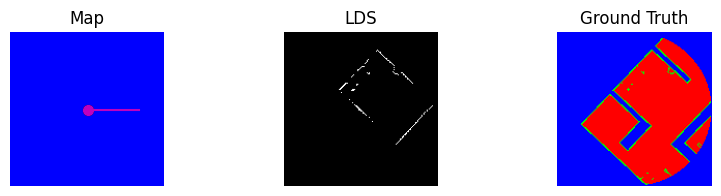

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1.         0.17887953 0.22063265 0.16403958]


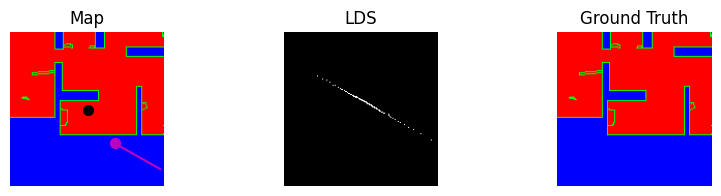

In [7]:
slam_data.show_dataset(train_data, 5)

## Model Training

map_shape: (149, 149, 3)
Map shape: (149, 149, 3) + padding (11, 11, 0)
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=11, h=11
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - adlo_output_accuracy: 0.4662 - adlo_output_adlo_loss: 0.2128 - loss: 1.3880 - map_output_accuracy: 0.5768 - map_output_map_loss: 1.1751
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 378ms/step - adlo_output_accuracy: 1.0000 - adlo_output_adlo_loss: 0.0759 - loss: 0.6710 - map_output_accuracy: 0.7475 - map_output_map_loss: 0.5951
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - adlo_output_accuracy: 1.0000 - adlo_output_adlo_loss: 0.0796 - loss: 0.6446 - map_output_accuracy: 0.7679 - map_output_map_loss: 0.5649
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - adlo_output_accuracy: 1.0000 - adlo_output_adlo_loss: 0.0722 - loss: 0.5937 - map_output_accuracy: 0.7907 - map_output_map_loss: 0.5215
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - adlo_output_accuracy: 1.0000

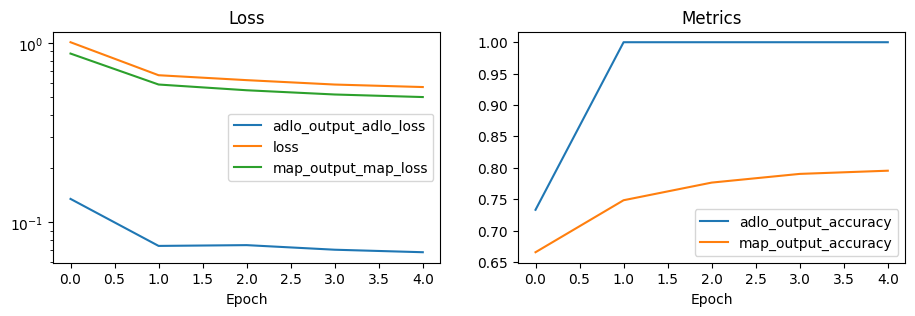

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
adlo:             [1. 0. 0. 0.]
adlo-predicted:   [ 0.9798717  -0.0044493  -0.0187557  -0.02451444]


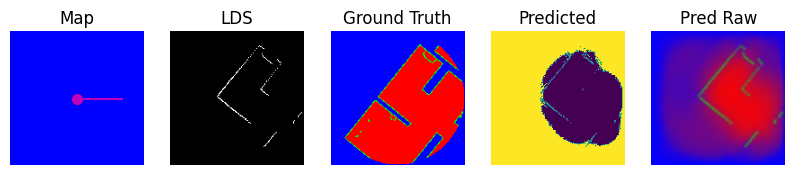

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
adlo:             [0. 0. 0. 0.]
adlo-predicted:   [ 6.1591566e-01  5.8834319e-04 -3.2746654e-03  3.8343150e-02]


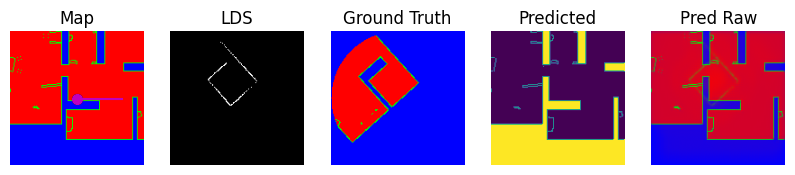

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-predicted:   [ 0.57627153  0.00290923 -0.00513914  0.01894427]


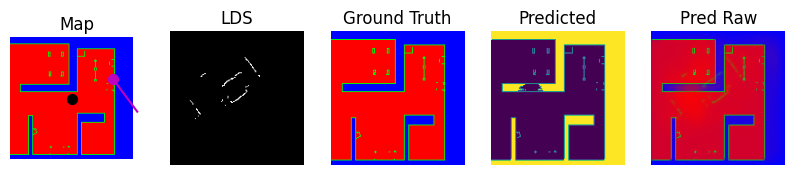

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
adlo:             [1. 0. 0. 0.]
adlo-predicted:   [ 0.97678566 -0.00665178 -0.01981251 -0.02114378]


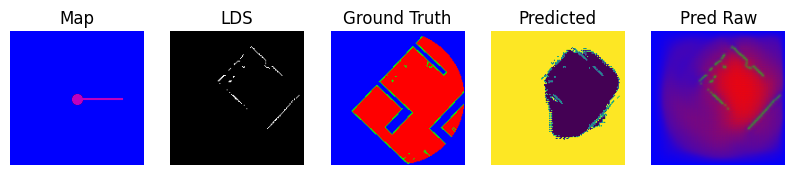

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-predicted:   [ 0.7382667  -0.00436931 -0.00277543  0.05264523]


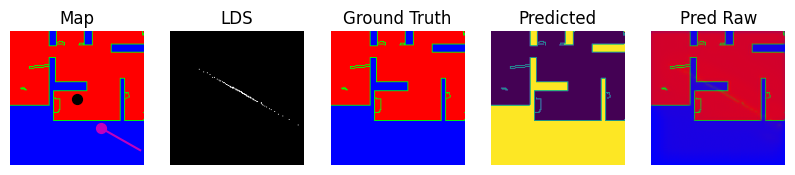

In [10]:
# Custom loss functions
# (out-of-the-box the two outputs get losses calculated independently,
#  ultimately I'll be wanting to conditionally choose whether the map loss
#  is considered depending on how the network is being used.
#  The easiest way to do that will be to generate the dataset so that the ground_truth_map
#  is blank for those cases)

def adlo_loss(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    # scale logits to correct ranges
    accept = tf.nn.sigmoid(y_pred[:, 0])
    delta_x = tf.nn.tanh(y_pred[:, 1]) * 0.5
    delta_y = tf.nn.tanh(y_pred[:, 2]) * 0.5
    delta_angle = tf.nn.tanh(y_pred[:, 3])
    y_pred_scaled = tf.stack([accept, delta_x, delta_y, delta_angle], axis=1)

    # apply simple MSE across the lot
    # (TODO be a little smarter)
    losses = tf.keras.losses.MSE(y_true, y_pred_scaled)
    return tf.reduce_mean(losses)

reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': adlo_loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='map_loss'), 'accuracy'],
                  'adlo_output': [adlo_loss, 'accuracy']
              })

epochs = 5
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

In [74]:
s = 'some'
s in ('none', 'all')

False

In [55]:
l = list(zip(batch[0], batch[1], preds))
len(l)

2

In [30]:
one = next(iter(train_data))
map = one[0][0]
w, h = tf.gather(map.shape, [1,0]).numpy()
w, h = map.shape[0:2]
h

149